In [67]:
import pandas as pd

Read the clean data we need from the ETL process

In [68]:
book_dim = pd.read_csv('../ssis_data/book_dim.csv')
fact_table = pd.read_csv('../ssis_data/rbook_fact.csv')

Merge the book_fact and category_dim dataframes together on the category_id column

In [69]:
data = pd.merge(fact_table, book_dim, left_on='Book', right_on='id_book')
data    

,Book,Author,PublishedDate,Category,SoldBy,Rating,price,id_book,label_title,label_reviews,label_isKindleUnlimited,label_isBestSeller,label_isEditorsPick,label_isGoodReadsChoice
0,129211,59963,4719,21,22,4.6,9.99,129211,Your Babyβ€™s Bottle-feeding Aversion: Reasons...,0,False,False,False,False
1,129229,60109,4694,21,22,4.6,9.99,129229,22 Things a Woman with Asperger's Syndrome Wan...,0,False,False,False,False
2,52783,40586,2538,21,22,4.6,9.99,52783,Oppositional Defiant Disorder Activities: 100 ...,0,False,False,False,False
3,33494,57022,198,21,22,4.6,9.99,33494,Raising Resilient Kids: 8 Principles for Bring...,0,False,False,False,False
4,33689,18685,924,21,22,4.6,9.99,33689,Conquer Negative Thinking for Teens: A Workboo...,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83699,32045,13467,4941,31,6,4.5,11.99,32045,"Oh, Florida!: How America's Weirdest State Inf...",491,False,False,False,False
83700,58620,34748,1560,31,6,4.5,11.99,58620,Counter Intelligence: Where to Eat in the Real...,128,False,False,False,False
83701,42786,45923,6245,31,6,4.5,11.99,42786,Golden Boy: Memories of a Hong Kong Childhood,130,False,False,False,False
83702,120029,18299,7028,31,6,4.5,11.99,120029,Dinosaurs in the Attic: An Excursion into the ...,240,False,False,False,False


Filter the data to include only books that have more than 10 reviews and are best sellers
and keep only the columns we need.

In [70]:
# Filter the data dataframe to only include the rows where label_reviews > 10 and label_isBestSeller = True
data = data[(data['label_reviews'] > 10) & (data['label_isBestSeller'] == True)]

# Make the id_book the index of the data dataframe
data = data.set_index('Book')

# Keep only the columns Rating, label_title and price
data = data[['Rating', 'label_title', 'price']]
data

,Rating,label_title,price
Book,,,
67450,4.6,Pixar Storytelling: Rules for Effective Storyt...,9.99
46795,4.6,Woodworking Bible: Discover Essential Tools an...,9.99
100920,4.6,The Science of Storytelling: Why Stories Make ...,9.99
28426,4.6,"Lonely Planet Munich, Bavaria & the Black Fore...",9.99
87801,4.6,Lonely Planet British Columbia & the Canadian ...,9.99
...,...,...,...
38532,4.4,Positively 4th Street: The Lives and Times of ...,11.99
115817,4.4,The Lost King: The Search for Richard III,11.99
120366,4.4,Babylon: Mesopotamia and the Birth of Civiliza...,11.99


Let's see the distribution of the ratings

In [71]:
data['Rating'].describe()

count    660.000000
mean       4.494848
std        0.306288
min        1.000000
25%        4.400000
50%        4.500000
75%        4.700000
max        5.000000
Name: Rating, dtype: float64

We can see that the average rating is 4.49 and the median is 4.5, so we will consider books with rating equal or above 4.5 as high rated.
Also, we can see that from out data that we have outliers with rating equal or below 3, that will skew the data
and thus the clustering, so we will remove them.

In [72]:
# Remove outliers with rating equal or below 3 because they skew the data
data = data[data['Rating'] > 3]

Now we will make a copy of the data to avoid warnings

In [73]:
data = data.copy() 

## Now we will perform sentiment analysis for the book titles that we have

First, we will load the data in a custom dataset class for improved performance.

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline
from tqdm.auto import tqdm


# Custom Dataset class for titles for improved performance
class TitlesDataset(Dataset):
    def __init__(self, titles):
        self.titles = titles

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, idx):
        return str(self.titles[idx])  # Ensure each item is a string

# Initialize the custom dataset
dataset = TitlesDataset(data['label_title'].tolist())

Now we will load the sentiment analysis model and process the data in batches.
We will use the `pipeline` function from the `transformers` library to load the sentiment analysis model.
The model we are using is the `lxyuan/distilbert-base-multilingual-cased-sentiments-student` model, that
is a student model of the `distilbert-base-multilingual-cased` model, 
that is a multilingual model that supports 104 languages.

We will also use the `tqdm` library to show a progress bar.

In [75]:
# Create a DataLoader for batching
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load the sentiment analysis model
device = 0 if torch.cuda.is_available() else -1
sentiment_analyzer = pipeline('sentiment-analysis',
                              model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
                              device=device)

# Process the data in batches
sentiments = []
for batch in tqdm(data_loader, desc="Processing Batches"):
    batch_sentiments = sentiment_analyzer(batch)
    sentiments.extend(batch_sentiments)

# Add the results to the DataFrame
data.loc[:, 'sentiment'] = sentiments

Processing Batches:   0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\panagiotis\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Now we will create a function to extract the label and score from the sentiment column

In [76]:
# Function to parse the sentiment column

# Updated function to handle dictionary input
def extract_label_and_score(data_dict):
    if isinstance(data_dict, dict) and 'label' in data_dict and 'score' in data_dict:
        label = data_dict['label']  # Extract label directly from dict
        score = float(data_dict['score'])  # Extract score and convert to float
        return label, score
    else:
        return None, None

In [77]:
# Apply the function and assign results directly in the original DataFrame using .loc
data[['sentiment_label', 'sentiment_score']] = data['sentiment'].apply(
    lambda x: pd.Series(extract_label_and_score(x))
)
data

,Rating,label_title,price,sentiment,sentiment_label,sentiment_score
Book,,,,,,
67450,4.6,Pixar Storytelling: Rules for Effective Storyt...,9.99,"{'label': 'positive', 'score': 0.8223946690559...",positive,0.822395
46795,4.6,Woodworking Bible: Discover Essential Tools an...,9.99,"{'label': 'positive', 'score': 0.7883983254432...",positive,0.788398
100920,4.6,The Science of Storytelling: Why Stories Make ...,9.99,"{'label': 'positive', 'score': 0.6226099133491...",positive,0.622610
28426,4.6,"Lonely Planet Munich, Bavaria & the Black Fore...",9.99,"{'label': 'positive', 'score': 0.6506907939910...",positive,0.650691
87801,4.6,Lonely Planet British Columbia & the Canadian ...,9.99,"{'label': 'positive', 'score': 0.6233068108558...",positive,0.623307
...,...,...,...,...,...,...
38532,4.4,Positively 4th Street: The Lives and Times of ...,11.99,"{'label': 'positive', 'score': 0.6341271996498...",positive,0.634127
115817,4.4,The Lost King: The Search for Richard III,11.99,"{'label': 'negative', 'score': 0.4406593739986...",negative,0.440659
120366,4.4,Babylon: Mesopotamia and the Birth of Civiliza...,11.99,"{'label': 'positive', 'score': 0.5261764526367...",positive,0.526176


Let's see how many positive labels we have out of the total

In [78]:
data[data['sentiment_label'] == 'positive']['sentiment_score'].describe()

count    614.000000
mean       0.654569
std        0.123656
min        0.400696
25%        0.563157
50%        0.641471
75%        0.741637
max        0.963157
Name: sentiment_score, dtype: float64

We can see that the vast majority of the titles are positive,
 we can also observe that hugginface's sentiment analysis model is biased towards positive labels,
 so we will adjust the sentiment labels to be more balanced.
 
1) When sentiment label is positive and score is less than 0.55 we will make the sentiment label neutral, and we 
choose 0.55 as the threshold because it is the 25th percentile of the positive scores.
2) When sentiment label is positive and score is less than 0.75 but more than 0.55 we will make the sentiment label somewhat positive, and we
this range because it between the 50th and 75th percentile of the positive scores.


In [79]:
# Adjust the sentiments to be from negative - neutral - somewhat positive - positive
# instead of negative - neutral - positive

# Case 1: when sentiment label is positive and score is less than 0.55 make the sentiment label neutral
data.loc[(data['sentiment_label'] == 'positive') & (data['sentiment_score'] < 0.55), 'sentiment_label'] = 'neutral'
# Case 2: when sentiment label is positive and score is less than 0.75 but more than 0.55 make the sentiment label somewhat positive
data.loc[(data['sentiment_label'] == 'positive') & (data['sentiment_score'] < 0.75) & (data['sentiment_score'] >= 0.55), 'sentiment_label'] = 'somewhat positive'

In [80]:
data['sentiment_label'].value_counts()

sentiment_label
somewhat positive    340
positive             141
neutral              135
negative              42
Name: count, dtype: int64

Now that the sentiment labels are more balanced, we will encode them into numerical values.
We will also add to the clustering the Rating and price columns, and we will scale them.

In [81]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Selecting relevant columns
data_for_clustering = data[['Rating', 'price', 'sentiment_label']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Rating', 'price']),
        ('cat', OneHotEncoder(), ['sentiment_label'])
    ])

In [82]:
# Apply the transformations
data_preprocessed = preprocessor.fit_transform(data_for_clustering)

We will now perform K-Elbow clustering to find the optimal number of clusters.

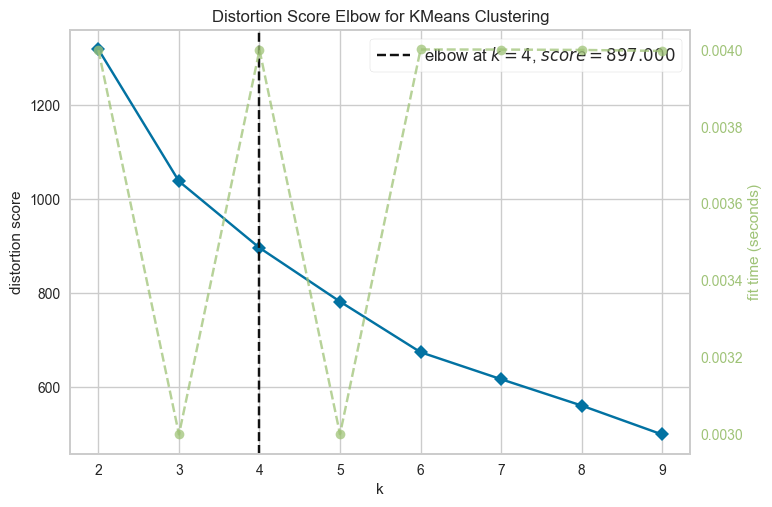

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [83]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Perform the elbow method to find the optimal number of clusters
model = KMeans(n_init='auto', max_iter=1000, random_state=0)
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(data_preprocessed)
visualizer.show()

Also, we will perform silhouette analysis to find the optimal number of clusters.

In [84]:
# Sort the silhouette scores for k = 2 to 5
from sklearn.metrics import silhouette_score

scores = []

for i in range(2, 6):
    model = KMeans(n_clusters=i, n_init='auto', max_iter=1000, random_state=42)
    model.fit(data_preprocessed)
    score = silhouette_score(data_preprocessed, model.labels_)
    scores.append({'k': i, 'score': score})

scores.sort(key=lambda x: x['score'], reverse=True)
scores

[{'k': 4, 'score': 0.2357621156972454},
 {'k': 2, 'score': 0.23175218918128346},
 {'k': 3, 'score': 0.2230244611611078},
 {'k': 5, 'score': 0.21730078066536498}]

We can see that the optimal number of clusters is 4, according to the elbow method and silhouette analysis.

However, we will perform K-Means clustering with three clusters because 
it is more useful for our use case, as we will see later.

In [96]:
# Choosing an appropriate number of clusters (k)
k = 3  # Adjust the number of clusters as needed

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=1000)
kmeans.fit(data_preprocessed)

# Assigning the clusters to each row in the dataframe
data.loc[:, 'cluster'] = kmeans.labels_
data

,Rating,label_title,price,sentiment,sentiment_label,sentiment_score,cluster,is_hight_rated
Book,,,,,,,,
67450,4.6,Pixar Storytelling: Rules for Effective Storyt...,9.99,"{'label': 'positive', 'score': 0.8223946690559...",positive,0.822395,1,True
46795,4.6,Woodworking Bible: Discover Essential Tools an...,9.99,"{'label': 'positive', 'score': 0.7883983254432...",positive,0.788398,1,True
100920,4.6,The Science of Storytelling: Why Stories Make ...,9.99,"{'label': 'positive', 'score': 0.6226099133491...",somewhat positive,0.622610,1,True
28426,4.6,"Lonely Planet Munich, Bavaria & the Black Fore...",9.99,"{'label': 'positive', 'score': 0.6506907939910...",somewhat positive,0.650691,1,True
87801,4.6,Lonely Planet British Columbia & the Canadian ...,9.99,"{'label': 'positive', 'score': 0.6233068108558...",somewhat positive,0.623307,1,True
...,...,...,...,...,...,...,...,...
38532,4.4,Positively 4th Street: The Lives and Times of ...,11.99,"{'label': 'positive', 'score': 0.6341271996498...",somewhat positive,0.634127,1,False
115817,4.4,The Lost King: The Search for Richard III,11.99,"{'label': 'negative', 'score': 0.4406593739986...",negative,0.440659,1,False
120366,4.4,Babylon: Mesopotamia and the Birth of Civiliza...,11.99,"{'label': 'positive', 'score': 0.5261764526367...",neutral,0.526176,1,False


In [97]:
# Group by the cluster column and calculate the count of each cluster
data.groupby('cluster').count().T.head(1)

cluster,0,1,2
Rating,243,251,164


Now we will visualize the clusters using a scatter plot,
where the x-axis is the Rating, the y-axis is the price, the color is the cluster, and the style is the sentiment label.

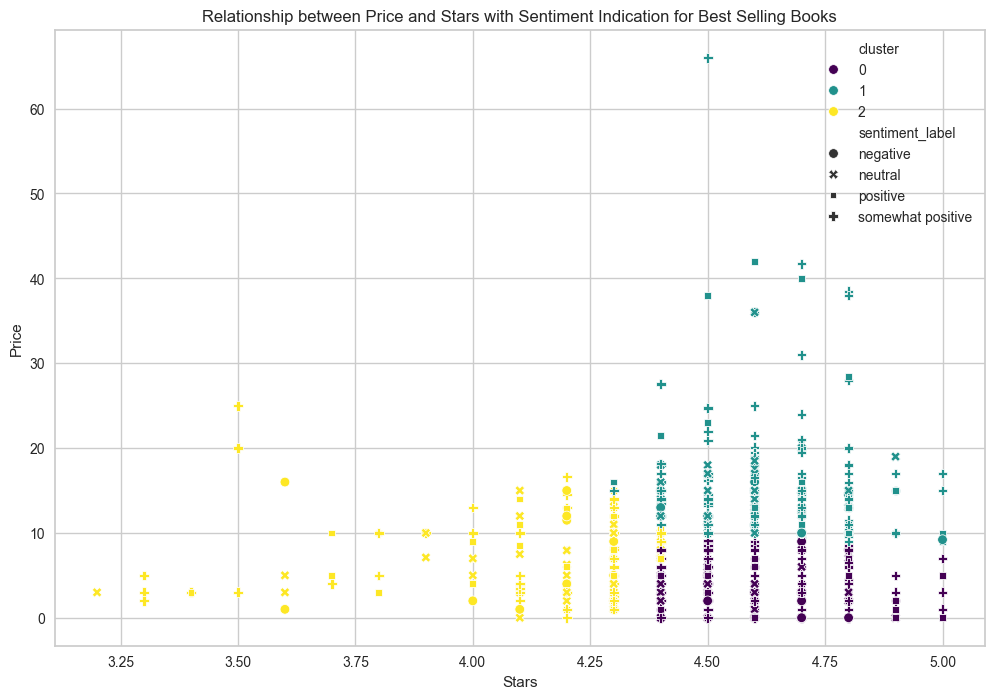

In [98]:
from matplotlib import pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Rating', y='price', hue='cluster', style='sentiment_label', palette='viridis')

# Setting plot title and labels
plt.title('Relationship between Price and Stars with Sentiment Indication for Best Selling Books')
plt.xlabel('Stars')
plt.ylabel('Price')

# Save the plot
plt.savefig('price_stars_sentiment.png')

# Show the plot
plt.show()

Now we will perform hypothesis testing to see if there is a relationship between the sentiment label and the rating.
We will use the Chi-Square Test of Independence.

In [99]:
import scipy.stats as stats
import math 

# Create a new column to indicate if the rating is high or not
data['is_hight_rated'] = data['Rating'] >= 4.5

# Make sure the sentiment_label column is of type category
data['sentiment_label'] = data['sentiment_label'].astype('category')

crosstab = pd.crosstab(data['is_hight_rated'], data['sentiment_label'])

# Perform the Chi-Square Test of Independence
chi2, p, dof, expected = stats.chi2_contingency(crosstab)

print(f'Chi-Square: {chi2}')
# Show the p-value
print(f'p-value: {math.floor(p * 100) / 100}')

Chi-Square: 7.616835368579997
p-value: 0.05


We can see that the p-value is 0.5,just at the threshold of 0.5, so we can't reject the null hypothesis that there is no relationship between the sentiment label and the rating.

Now we will see the percentage change between the observed and expected frequencies.

In [100]:
percentage_change = ((crosstab - expected) / expected) * 100
percentage_change

sentiment_label,negative,neutral,positive,somewhat positive
is_hight_rated,,,,
False,12.376934,25.450852,-1.547117,-10.992802
True,-6.967538,-14.327439,0.870942,6.188347


We can clearly see that the percentage change for the positive sentiment label is very small, however, the percentage change for the somewhat positive sentiment label and the negative and neutral sentiment labels are significant which means that there is a relationship between the somewhat positive sentiment label and the rating, and between the negative and neutral sentiment labels and the rating.

More specifically, we can see that the somewhat positive sentiment label has a positive relationship with the rating,
 and the negative and neutral sentiment labels have a negative relationship with the rating.